In [4]:
#code implemented
# https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html

In [1]:
import networkx as nx

In [27]:
# Stellar graph requires python 3.6

from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from IPython.display import display, HTML
%matplotlib inline

In [63]:
# from scipy.sparse import load_npz

# adj_matrix = load_npz("adj_matrix.npz")

In [113]:
# len(adj_matrix.toarray())

In [95]:
!pip3 install pickle5
import pickle5 as pickle

with open("following_dict.pkl", "rb") as file:
    following_dict = pickle.load(file)

In [184]:
users_data = pd.read_csv("data/profiles/extended_df_complete.csv")
users_data_clean = users_data.drop_duplicates(subset=["acct"], keep="first")
users_data_clean = users_data_clean[users_data_clean["acct"].isin(following_dict.keys())]

In [185]:
len(users_data_clean)

1528

24700

In [287]:
following_dict['Anas']

[{'id': '108281471355576477',
  'acct': 'ntnsndr@social.coop',
  'url': 'https://social.coop/@ntnsndr',
  'created_at': '2017-04-26T00:00:00.000Z',
  'followers_count': 2636,
  'following_count': 701,
  'statuses_count': 4633,
  'last_status_at': '2023-11-24',
  'instance': 'https://social.coop/'},
 {'id': '109383542503003937',
  'acct': 'hlauriejones',
  'url': 'https://hci.social/@hlauriejones',
  'created_at': '2022-11-21T00:00:00.000Z',
  'followers_count': 1,
  'following_count': 15,
  'statuses_count': 0,
  'last_status_at': '2023-02-16',
  'instance': 'https://hci.social/'},
 {'id': '109381349901173914',
  'acct': 'rodlux@maly.io',
  'url': 'https://maly.io/@rodlux',
  'created_at': '2022-11-20T00:00:00.000Z',
  'followers_count': 552,
  'following_count': 2953,
  'statuses_count': 1315,
  'last_status_at': '2023-11-21',
  'instance': 'https://maly.io/'},
 {'id': '108280940426884986',
  'acct': 'evanmpeck',
  'url': 'https://hci.social/@evanmpeck',
  'created_at': '2022-05-11T00

In [319]:
type(str(users_data_clean[users_data_clean["acct"] == "Anas"]['id'].values[0]))

str

In [318]:
type(following_dict['Anas'][0]['id'])

str

In [341]:
G_hci = nx.DiGraph()
# use either dict as a statign point because they have the same keys!
G_hci.add_nodes_from(users_data_clean["id"].values)
G_hci.number_of_nodes()

1528

In [342]:
# loop over the df

for index, user in list(users_data_clean.iterrows()):
    this_node = user["acct"]
    user_id = str(users_data_clean[users_data_clean["acct"] == this_node]["id"].values[0])

    if user_id not in G_hci:
        G_hci.add_node(this_node)

    # add the following edges
    for user_following in following_dict[this_node]:
        following_node = user_following["id"]

        if "@" in following_node:
            # only get the local instance
            # i.e. keep only hci.social
            continue

        if following_node not in G_hci.nodes:
            G_hci.add_node(following_node)
 
        candidate_edge = (user_id, following_node)

        if candidate_edge not in G_hci.edges:
            G_hci.add_edge(*candidate_edge)

In [343]:
G_hci.number_of_nodes()

24888

In [333]:
len(set(G_hci.nodes))

24888

In [272]:
G_hci.number_of_edges()

85108

### Create features matrix

In [ ]:
#create dataframe for features
# https://stackoverflow.com/questions/42806398/create-adjacency-matrix-for-two-columns-in-pandas-dataframe

In [157]:
# adj_matrix_df = pd.DataFrame(nx.to_numpy_array(G_hci), columns=G_hci.nodes, index=G_hci.nodes)

In [207]:
users_data_clean["created_at"] = pd.to_datetime(
    users_data_clean["created_at"]
)  # conver

users_data_clean["unix_timestamp"] = (
    users_data_clean["created_at"].astype(int) // 10**9
)  # Convert nanoseconds to secondst to datetime

In [233]:
features = users_data_clean[
    ["id","unix_timestamp", "followers_count", "following_count", "statuses_count"]
]
features = features.set_index("id")

In [234]:
features.head()

,unix_timestamp,followers_count,following_count,statuses_count
id,,,,
108286624813793740,1652313600,48,20,24
108286142941695868,1652313600,368,271,36
108286014897638184,1652227200,13,9,1
108285815791532398,1652227200,39,22,37
108285424167487793,1652227200,12,20,0


In [229]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 0 to 2161
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               1528 non-null   int64
 1   unix_timestamp   1528 non-null   int64
 2   followers_count  1528 non-null   int64
 3   following_count  1528 non-null   int64
 4   statuses_count   1528 non-null   int64
dtypes: int64(5)
memory usage: 71.6 KB


### Preparing the graph

In [235]:
G = StellarGraph.from_networkx(
    G_hci.to_undirected(),
    node_type_default="user",
    edge_type_default="follows",
    node_features=features,
)

In [236]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1528, Edges: 0

 Node types:
  user: [1528]
    Features: float32 vector, length 4
    Edge types: none

 Edge types:


In [238]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

IndexError: single positional indexer is out-of-bounds

In [143]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 2379 positive and 2379 negative edges. **


### Creating the GCN link model

In [144]:
epochs = 10

In [145]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [146]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [147]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [148]:
x_inp, x_out = gcn.in_out_tensors()

In [149]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [150]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [151]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

c:\Users\bhiha\anaconda3\envs\stellargraph-env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [152]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 109ms/step - loss: 1.6737 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 1.6619
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 1.6737
	acc: 0.0000


#### Train the model

In [153]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/10
1/1 - 1s - loss: 1.6022 - acc: 0.0000e+00 - val_loss: 3.8070 - val_acc: 0.0000e+00
Epoch 2/10
1/1 - 0s - loss: 3.9069 - acc: 0.0000e+00 - val_loss: 2.8701 - val_acc: 0.0000e+00
Epoch 3/10
1/1 - 0s - loss: 2.8065 - acc: 0.0000e+00 - val_loss: 2.2929 - val_acc: 0.0000e+00
Epoch 4/10
1/1 - 0s - loss: 2.2551 - acc: 0.0000e+00 - val_loss: 1.2291 - val_acc: 0.0000e+00
Epoch 5/10
1/1 - 0s - loss: 1.2703 - acc: 0.0000e+00 - val_loss: 0.4322 - val_acc: 0.0000e+00
Epoch 6/10
1/1 - 0s - loss: 0.4070 - acc: 0.0000e+00 - val_loss: 0.5781 - val_acc: 0.0000e+00
Epoch 7/10
1/1 - 0s - loss: 0.5684 - acc: 0.0000e+00 - val_loss: 0.4457 - val_acc: 0.0000e+00
Epoch 8/10
1/1 - 0s - loss: 0.4136 - acc: 0.0000e+00 - val_loss: 0.5764 - val_acc: 0.0000e+00
Epoch 9/10
1/1 - 0s - loss: 0.6588 - acc: 0.0000e+00 - val_loss: 0.9112 - val_acc: 0.0000e+00
Epoch 10/10
1/1 - 0s - loss: 0.8812 - acc: 0.0000e+00 - val_loss: 0.7976 - val_acc: 0.0000e+00


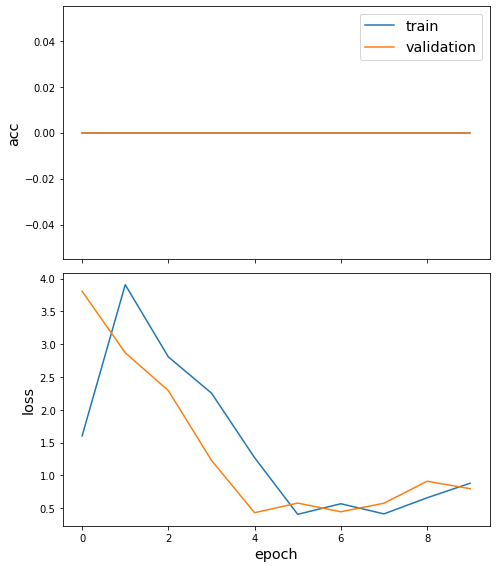

In [154]:
sg.utils.plot_history(history)

In [155]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 111ms/step - loss: 0.7976 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 0.8208
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 0.7976
	acc: 0.0000
